<h1><center><font size="6">Preprocessing Notebook</font></center></h1>


# Importing Packages

In [178]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import re as regex
import pickle

import plotly
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from plotly import graph_objs
import plotly.graph_objs as go
import chart_studio.plotly as py
plotly.offline.init_notebook_mode()
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text.tsne import tsne
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob, Word


%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../py")
from utils import *
from preprocess import *

# Original Dataset

In [2]:
df = pd.read_csv("../data/labeled_data.csv", index_col=0)
df.head()

count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [3]:
df.shape

(24783, 6)

In [4]:
df = df.rename(columns={"hate_speech": 'hate', "offensive_language": 'offensive', "neither": 'neutral', "class": 'target'})
df.head()

count  hate  offensive  neutral  target  \
0      3     0          0        3       2   
1      3     0          3        0       1   
2      3     0          3        0       1   
3      3     0          2        1       1   
4      6     0          6        0       1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [5]:
hate = len(df[df['target'] == 0])
off = len(df[df['target'] == 1])
neu = len(df[df['target'] == 2])
dist = [
    graph_objs.Bar(
        x=["hate","offensive","neutral"],
        y=[hate, off, neu],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Class Distribution")})

# EDA and Feature Engineering

In [6]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [7]:
df.tweet.head(30)

0     !!! RT @mayasolovely: As a woman you shouldn't...
1     !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2     !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3     !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5     !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6     !!!!!!"@__BrighterDays: I can not just sit up ...
7     !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8     " &amp; you might not get ya bitch back &amp; ...
9     " @rhythmixx_ :hobbies include: fighting Maria...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

## Word Count Per Tweet

In [8]:
def num_of_words(df, col):
    df['word_ct'] = df[col].apply(lambda x: len(str(x).split(" ")))
    print(df[[col, 'word_ct']])

num_of_words(df, 'tweet')

                                                   tweet  word_ct
0      !!! RT @mayasolovely: As a woman you shouldn't...       25
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       16
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...       21
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...        9
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...       26
...                                                  ...      ...
25291  you's a muthaf***in lie &#8220;@LifeAsKing: @2...       19
25292  you've gone and broke the wrong heart baby, an...       13
25294  young buck wanna eat!!.. dat nigguh like I ain...       13
25295              youu got wild bitches tellin you lies        7
25296  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...       18

[24783 rows x 2 columns]


In [9]:
df.word_ct.value_counts().sort_values(ascending=False)

9     1398
10    1391
7     1358
11    1340
8     1335
12    1270
13    1232
6     1095
14    1091
16    1063
15    1033
18    1023
5      957
17     925
19     856
21     839
20     835
22     810
23     778
4      725
24     668
25     617
26     512
3      455
27     396
28     247
2      210
29     169
30      81
31      43
32      17
1        8
33       5
36       1
Name: word_ct, dtype: int64

In [10]:
df

count  hate  offensive  neutral  target  \
0          3     0          0        3       2   
1          3     0          3        0       1   
2          3     0          3        0       1   
3          3     0          2        1       1   
4          6     0          6        0       1   
...      ...   ...        ...      ...     ...   
25291      3     0          2        1       1   
25292      3     0          1        2       2   
25294      3     0          3        0       1   
25295      6     0          6        0       1   
25296      3     0          0        3       2   

                                                   tweet  word_ct  
0      !!! RT @mayasolovely: As a woman you shouldn't...       25  
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       16  
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...       21  
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...        9  
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...       26  
...                                                  ...      ...  
25291  you's a muthaf***in lie &#8220;@LifeAsKing: @2...       19  
25292  you've gone and broke the wrong heart baby, an...       13  
25294  young buck wanna eat!!.. dat nigguh like I ain...       13  
25295              youu got wild bitches tellin you lies        7  
25296  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...       18  

[24783 rows x 7 columns]

In [11]:
df['word_ct'].iplot(
    kind='hist',
    bins=40,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Word Count Distribution')

## Number of Characters Per Tweet

In [12]:
def num_of_chars(df, col):
    df['char_ct'] = df[col].str.len()
    print(df[[col, 'char_ct']])

num_of_chars(df, 'tweet')

                                                   tweet  char_ct
0      !!! RT @mayasolovely: As a woman you shouldn't...      140
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       85
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      120
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...       62
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      137
...                                                  ...      ...
25291  you's a muthaf***in lie &#8220;@LifeAsKing: @2...      146
25292  you've gone and broke the wrong heart baby, an...       70
25294  young buck wanna eat!!.. dat nigguh like I ain...       67
25295              youu got wild bitches tellin you lies       37
25296  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...      127

[24783 rows x 2 columns]


In [13]:
df.char_ct.value_counts().sort_values(ascending=False)

146    794
140    423
139    277
64     246
58     245
      ... 
392      1
280      1
248      1
255      1
447      1
Name: char_ct, Length: 250, dtype: int64

In [14]:
df['char_ct'].iplot(
    kind='hist',
    bins=100,
    xTitle='character count',
    linecolor='black',
    yTitle='count',
    title='Character Count Distribution')

## Average Word Length Per Tweet

In [15]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

def avg_word_length(df, col):
    df['avg_wrd'] = df[col].apply(lambda x: avg_word(x))
    print(df[[col, 'avg_wrd']].head())

avg_word_length(df, 'tweet')

                                               tweet   avg_wrd
0  !!! RT @mayasolovely: As a woman you shouldn't...  4.640000
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  4.375000
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  4.761905
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  6.000000
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  4.307692


In [16]:
df['avg_wrd'].iplot(
    kind='hist',
    bins=60,
    xTitle='average word length',
    linecolor='black',
    yTitle='count',
    title='Average Word Length Distribution')

## Hashtags Count

In [17]:
def hash_tags(df, col):
    df['hashtags'] = df[col].apply(lambda x: len(re.split(r'#', str(x)))-1)
    print(df[[col, 'hashtags']].head())

hash_tags(df, 'tweet')

                                               tweet  hashtags
0  !!! RT @mayasolovely: As a woman you shouldn't...         0
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...         0
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...         0
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...         0
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...         1


In [18]:
df.hashtags.value_counts()

0     17138
1      3357
2      1890
3       953
4       515
5       278
6       199
7       150
8        95
9        61
10       35
13       21
11       21
12       20
14       12
15        5
18        4
24        4
23        3
27        2
47        2
17        2
25        2
16        2
28        1
65        1
77        1
66        1
39        1
19        1
20        1
36        1
21        1
40        1
22        1
63        1
Name: hashtags, dtype: int64

In [19]:
df['hashtags'].iplot(
    kind='hist',
    bins=100,
    xTitle='hashtags count',
    linecolor='black',
    yTitle='count',
    title='Number of Hashtags Distribution')

# Preprocessing of Tweets

In [20]:
df2 = df.copy()
df2.head()

count  hate  offensive  neutral  target  \
0      3     0          0        3       2   
1      3     0          3        0       1   
2      3     0          3        0       1   
3      3     0          2        1       1   
4      6     0          6        0       1   

                                               tweet  word_ct  char_ct  \
0  !!! RT @mayasolovely: As a woman you shouldn't...       25      140   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       16       85   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...       21      120   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...        9       62   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...       26      137   

    avg_wrd  hashtags  
0  4.640000         0  
1  4.375000         0  
2  4.761905         0  
3  6.000000         0  
4  4.307692         1

## Callouts and Retweets

In [21]:
def collect_and_remove_users(df, col):
    df['retweets'] = df[col].apply(lambda x: re.findall(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(x))) # remove re-tweet
    df.retweets = df.retweets.apply(lambda x: str(x)[1:-1])
    df['callouts'] = df[col].apply(lambda x: re.findall(r'(@[A-Za-z0-9-_]+)', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'(@[A-Za-z0-9-_]+)', '', str(x))) # remove tweeted at
    df.callouts = df.callouts.apply(lambda x: str(x)[1:-1])

collect_and_remove_users(df2, 'tweet')
df2.head(20)

count  hate  offensive  neutral  target  \
0       3     0          0        3       2   
1       3     0          3        0       1   
2       3     0          3        0       1   
3       3     0          2        1       1   
4       6     0          6        0       1   
5       3     1          2        0       1   
6       3     0          3        0       1   
7       3     0          3        0       1   
8       3     0          3        0       1   
9       3     1          2        0       1   
10      3     0          3        0       1   
11      3     0          3        0       1   
12      3     0          2        1       1   
13      3     0          3        0       1   
14      3     1          2        0       1   
15      3     0          3        0       1   
16      3     0          3        0       1   
17      3     1          2        0       1   
18      3     0          3        0       1   
19      3     0          3        0       1   

                                                tweet  word_ct  char_ct  \
0   !!! : As a woman you shouldn't complain about ...       25      140   
1   !!!!! : boy dats cold...tyga dwn bad for cuffi...       16       85   
2   !!!!!!!  Dawg!!!! RT : You ever fuck a bitch a...       21      120   
3                 !!!!!!!!! :  she look like a tranny        9       62   
4   !!!!!!!!!!!!! : The shit you hear about me mig...       26      137   
5   !!!!!!!!!!!!!!!!!!": The shit just blows me..c...       19      158   
6   !!!!!!": I can not just sit up and HATE on ano...       20      105   
7   !!!!&#8220;: cause I'm tired of you big bitche...       13       98   
8   " &amp; you might not get ya bitch back &amp; ...       13       58   
9      "  :hobbies include: fighting Mariam"\n\nbitch        6       55   
10  " Keeks is a bitch she curves everyone " lol I...       18       88   
11                 " Murda Gang bitch its Gang Land "        8       34   
12  " So hoes that smoke are losers ? " yea ... go...       14       52   
13      " bad bitches is the only thing that i like "       11       45   
14                            " bitch get up off me "        7       23   
15                    " bitch nigga miss me with it "        8       31   
16                             " bitch plz whatever "        5       22   
17                          " bitch who do you love "        7       25   
18                 " bitches get cut off everyday B "        8       34   
19                 " black bottle &amp; a bad bitch "        8       34   

     avg_wrd  hashtags              retweets           callouts  
0   4.640000         0    'RT @mayasolovely'                     
1   4.375000         0         'RT @mleew17'                     
2   4.761905         0   'RT @UrKindOfBrand'    '@80sbaby4life'  
3   6.000000         0    'RT @C_G_Anderson'      '@viva_based'  
4   4.307692         1  'RT @ShenikaRoberts'                     
5   7.368421         3                           '@T_Madison_x'  
6   4.300000         0                        '@__BrighterDays'  
7   6.615385         2                        '@selfiequeenbri'  
8   3.538462         0                                           
9   6.857143         0                            '@rhythmixx_'  
10  3.944444         0                                           
11  3.375000         0                                           
12  2.785714         0                                           
13  3.181818         0                                           
14  2.428571         0                                           
15  3.000000         0                                           
16  3.600000         0                                           
17  2.714286         0                                           
18  3.375000         0                                           
19  3.375000         0

## Character References

In [22]:
def collect_and_remove_charef(df, col):
    df['charref'] = df[col].apply(lambda x: re.findall(r'&[\S]+?;', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'&[\S]+?;', '', str(x)))
    df.charref = df.charref.apply(lambda x: str(x)[1:-1])

collect_and_remove_charef(df2, 'tweet')
df2.head(20)

count  hate  offensive  neutral  target  \
0       3     0          0        3       2   
1       3     0          3        0       1   
2       3     0          3        0       1   
3       3     0          2        1       1   
4       6     0          6        0       1   
5       3     1          2        0       1   
6       3     0          3        0       1   
7       3     0          3        0       1   
8       3     0          3        0       1   
9       3     1          2        0       1   
10      3     0          3        0       1   
11      3     0          3        0       1   
12      3     0          2        1       1   
13      3     0          3        0       1   
14      3     1          2        0       1   
15      3     0          3        0       1   
16      3     0          3        0       1   
17      3     1          2        0       1   
18      3     0          3        0       1   
19      3     0          3        0       1   

                                                tweet  word_ct  char_ct  \
0   !!! : As a woman you shouldn't complain about ...       25      140   
1   !!!!! : boy dats cold...tyga dwn bad for cuffi...       16       85   
2   !!!!!!!  Dawg!!!! RT : You ever fuck a bitch a...       21      120   
3                 !!!!!!!!! :  she look like a tranny        9       62   
4   !!!!!!!!!!!!! : The shit you hear about me mig...       26      137   
5   !!!!!!!!!!!!!!!!!!": The shit just blows me..c...       19      158   
6   !!!!!!": I can not just sit up and HATE on ano...       20      105   
7   !!!!: cause I'm tired of you big bitches comin...       13       98   
8    "  you might not get ya bitch back  thats that "       13       58   
9      "  :hobbies include: fighting Mariam"\n\nbitch        6       55   
10  " Keeks is a bitch she curves everyone " lol I...       18       88   
11                 " Murda Gang bitch its Gang Land "        8       34   
12  " So hoes that smoke are losers ? " yea ... go...       14       52   
13      " bad bitches is the only thing that i like "       11       45   
14                            " bitch get up off me "        7       23   
15                    " bitch nigga miss me with it "        8       31   
16                             " bitch plz whatever "        5       22   
17                          " bitch who do you love "        7       25   
18                 " bitches get cut off everyday B "        8       34   
19                      " black bottle  a bad bitch "        8       34   

     avg_wrd  hashtags              retweets           callouts  \
0   4.640000         0    'RT @mayasolovely'                      
1   4.375000         0         'RT @mleew17'                      
2   4.761905         0   'RT @UrKindOfBrand'    '@80sbaby4life'   
3   6.000000         0    'RT @C_G_Anderson'      '@viva_based'   
4   4.307692         1  'RT @ShenikaRoberts'                      
5   7.368421         3                           '@T_Madison_x'   
6   4.300000         0                        '@__BrighterDays'   
7   6.615385         2                        '@selfiequeenbri'   
8   3.538462         0                                            
9   6.857143         0                            '@rhythmixx_'   
10  3.944444         0                                            
11  3.375000         0                                            
12  2.785714         0                                            
13  3.181818         0                                            
14  2.428571         0                                            
15  3.000000         0                                            
16  3.600000         0                                            
17  2.714286         0                                            
18  3.375000         0                                            
19  3.375000         0                                            

                                

## Hashtags

In [23]:
def collect_and_remove_hashtags(df, col):
    df['hashtags'] = df[col].apply(lambda x: re.findall(r'(#[A-Za-z]+[A-Za-z0-9-_]+)', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'#', ' ', str(x)))
    df.hashtags = df.hashtags.apply(lambda x: str(x)[1:-1])

collect_and_remove_hashtags(df2, 'tweet')
df2.head(20)

count  hate  offensive  neutral  target  \
0       3     0          0        3       2   
1       3     0          3        0       1   
2       3     0          3        0       1   
3       3     0          2        1       1   
4       6     0          6        0       1   
5       3     1          2        0       1   
6       3     0          3        0       1   
7       3     0          3        0       1   
8       3     0          3        0       1   
9       3     1          2        0       1   
10      3     0          3        0       1   
11      3     0          3        0       1   
12      3     0          2        1       1   
13      3     0          3        0       1   
14      3     1          2        0       1   
15      3     0          3        0       1   
16      3     0          3        0       1   
17      3     1          2        0       1   
18      3     0          3        0       1   
19      3     0          3        0       1   

                                                tweet  word_ct  char_ct  \
0   !!! : As a woman you shouldn't complain about ...       25      140   
1   !!!!! : boy dats cold...tyga dwn bad for cuffi...       16       85   
2   !!!!!!!  Dawg!!!! RT : You ever fuck a bitch a...       21      120   
3                 !!!!!!!!! :  she look like a tranny        9       62   
4   !!!!!!!!!!!!! : The shit you hear about me mig...       26      137   
5   !!!!!!!!!!!!!!!!!!": The shit just blows me..c...       19      158   
6   !!!!!!": I can not just sit up and HATE on ano...       20      105   
7   !!!!: cause I'm tired of you big bitches comin...       13       98   
8    "  you might not get ya bitch back  thats that "       13       58   
9      "  :hobbies include: fighting Mariam"\n\nbitch        6       55   
10  " Keeks is a bitch she curves everyone " lol I...       18       88   
11                 " Murda Gang bitch its Gang Land "        8       34   
12  " So hoes that smoke are losers ? " yea ... go...       14       52   
13      " bad bitches is the only thing that i like "       11       45   
14                            " bitch get up off me "        7       23   
15                    " bitch nigga miss me with it "        8       31   
16                             " bitch plz whatever "        5       22   
17                          " bitch who do you love "        7       25   
18                 " bitches get cut off everyday B "        8       34   
19                      " black bottle  a bad bitch "        8       34   

     avg_wrd hashtags              retweets           callouts  \
0   4.640000             'RT @mayasolovely'                      
1   4.375000                  'RT @mleew17'                      
2   4.761905            'RT @UrKindOfBrand'    '@80sbaby4life'   
3   6.000000             'RT @C_G_Anderson'      '@viva_based'   
4   4.307692           'RT @ShenikaRoberts'                      
5   7.368421                                    '@T_Madison_x'   
6   4.300000                                 '@__BrighterDays'   
7   6.615385                                 '@selfiequeenbri'   
8   3.538462                                                     
9   6.857143                                     '@rhythmixx_'   
10  3.944444                                                     
11  3.375000                                                     
12  2.785714                                                     
13  3.181818                                                     
14  2.428571                                                     
15  3.000000                                                     
16  3.600000                                                     
17  2.714286                                                     
18  3.375000                                                     
19  3.375000                                                     

                                  charref  
0        

In [24]:
df2.hashtags.value_counts()

                               22741
'#Yankees'                        42
'#tcot'                           13
'#tbt'                            10
'#Ferguson'                        9
                               ...  
'#sorrynotsorry'                   1
'#muslims'                         1
'#you', '#are', '#retarded'        1
'#msnbc', '#morningjoe'            1
'#wrongfilmquotes'                 1
Name: hashtags, Length: 1728, dtype: int64

## QT, Audio, and Video Tags

In [25]:
def remove_av_qt(df, col):
    """Takes a column of strings in Pandas dataframe and removes AUDIO/VIDEO tags or labels"""    
    df[col] = df[col].apply(lambda x: re.sub(r'(\bQT\b)', '', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'VIDEO:', '', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'AUDIO:', '', str(x)))

remove_av_qt(df2, 'tweet')
df2.tweet.head(20)

0     !!! : As a woman you shouldn't complain about ...
1     !!!!! : boy dats cold...tyga dwn bad for cuffi...
2     !!!!!!!  Dawg!!!! RT : You ever fuck a bitch a...
3                   !!!!!!!!! :  she look like a tranny
4     !!!!!!!!!!!!! : The shit you hear about me mig...
5     !!!!!!!!!!!!!!!!!!": The shit just blows me..c...
6     !!!!!!": I can not just sit up and HATE on ano...
7     !!!!: cause I'm tired of you big bitches comin...
8      "  you might not get ya bitch back  thats that "
9        "  :hobbies include: fighting Mariam"\n\nbitch
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

## URLS

In [26]:
def collect_and_remove_links(df, col):
    df['links'] = df[col].apply(lambda x: re.findall(r'http\S+', str(x))) 
    df[col] = df[col].apply(lambda x: re.sub(r'http\S+', '', str(x)))  # remove http links
    df['links'] = df[col].apply(lambda x: re.findall(r'bit.ly/\S+', str(x))) 
    df[col] = df[col].apply(lambda x: re.sub(r'bit.ly/\S+', '', str(x)))  # remove bit.ly links    
    df.links = df.links.apply(lambda x: str(x)[1:-1]) # remove brackets around list

collect_and_remove_links(df2, "tweet")
df2.head(20)

count  hate  offensive  neutral  target  \
0       3     0          0        3       2   
1       3     0          3        0       1   
2       3     0          3        0       1   
3       3     0          2        1       1   
4       6     0          6        0       1   
5       3     1          2        0       1   
6       3     0          3        0       1   
7       3     0          3        0       1   
8       3     0          3        0       1   
9       3     1          2        0       1   
10      3     0          3        0       1   
11      3     0          3        0       1   
12      3     0          2        1       1   
13      3     0          3        0       1   
14      3     1          2        0       1   
15      3     0          3        0       1   
16      3     0          3        0       1   
17      3     1          2        0       1   
18      3     0          3        0       1   
19      3     0          3        0       1   

                                                tweet  word_ct  char_ct  \
0   !!! : As a woman you shouldn't complain about ...       25      140   
1   !!!!! : boy dats cold...tyga dwn bad for cuffi...       16       85   
2   !!!!!!!  Dawg!!!! RT : You ever fuck a bitch a...       21      120   
3                 !!!!!!!!! :  she look like a tranny        9       62   
4   !!!!!!!!!!!!! : The shit you hear about me mig...       26      137   
5   !!!!!!!!!!!!!!!!!!": The shit just blows me..c...       19      158   
6   !!!!!!": I can not just sit up and HATE on ano...       20      105   
7   !!!!: cause I'm tired of you big bitches comin...       13       98   
8    "  you might not get ya bitch back  thats that "       13       58   
9      "  :hobbies include: fighting Mariam"\n\nbitch        6       55   
10  " Keeks is a bitch she curves everyone " lol I...       18       88   
11                 " Murda Gang bitch its Gang Land "        8       34   
12  " So hoes that smoke are losers ? " yea ... go...       14       52   
13      " bad bitches is the only thing that i like "       11       45   
14                            " bitch get up off me "        7       23   
15                    " bitch nigga miss me with it "        8       31   
16                             " bitch plz whatever "        5       22   
17                          " bitch who do you love "        7       25   
18                 " bitches get cut off everyday B "        8       34   
19                      " black bottle  a bad bitch "        8       34   

     avg_wrd hashtags              retweets           callouts  \
0   4.640000             'RT @mayasolovely'                      
1   4.375000                  'RT @mleew17'                      
2   4.761905            'RT @UrKindOfBrand'    '@80sbaby4life'   
3   6.000000             'RT @C_G_Anderson'      '@viva_based'   
4   4.307692           'RT @ShenikaRoberts'                      
5   7.368421                                    '@T_Madison_x'   
6   4.300000                                 '@__BrighterDays'   
7   6.615385                                 '@selfiequeenbri'   
8   3.538462                                                     
9   6.857143                                     '@rhythmixx_'   
10  3.944444                                                     
11  3.375000                                                     
12  2.785714                                                     
13  3.181818                                                     
14  2.428571                                                     
15  3.000000                                                     
16  3.600000                                                     
17  2.714286                                                     
18  3.375000                                                     
19  3.375000                                                     

                                  charref links  
0  

## Punctuation

In [27]:
def remove_punctuation(df, col):    
    df[col] = df[col].apply(lambda x: re.sub(r'[^\w\s]', r'', str(x)))

remove_punctuation(df2, 'tweet')
df2.tweet.head(20)

0       As a woman you shouldnt complain about clean...
1       boy dats coldtyga dwn bad for cuffin dat hoe...
2       Dawg RT  You ever fuck a bitch and she start...
3                                she look like a tranny
4       The shit you hear about me might be true or ...
5      The shit just blows meclaim you so faithful a...
6      I can not just sit up and HATE on another bit...
7      cause Im tired of you big bitches coming for ...
8          you might not get ya bitch back  thats that 
9              hobbies include fighting Mariam\n\nbitch
10     Keeks is a bitch she curves everyone  lol I w...
11                      Murda Gang bitch its Gang Land 
12        So hoes that smoke are losers   yea  go on IG
13           bad bitches is the only thing that i like 
14                                 bitch get up off me 
15                         bitch nigga miss me with it 
16                                  bitch plz whatever 
17                               bitch who do yo

## Lower Casing

In [28]:
# lower casing
def lowercasing(df, col):
    df[col] = df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))

lowercasing(df2, 'tweet')
df2.tweet.head(20)

0     as a woman you shouldnt complain about cleanin...
1     boy dats coldtyga dwn bad for cuffin dat hoe i...
2     dawg rt you ever fuck a bitch and she start to...
3                                she look like a tranny
4     the shit you hear about me might be true or it...
5     the shit just blows meclaim you so faithful an...
6     i can not just sit up and hate on another bitc...
7     cause im tired of you big bitches coming for u...
8            you might not get ya bitch back thats that
9                 hobbies include fighting mariam bitch
10    keeks is a bitch she curves everyone lol i wal...
11                       murda gang bitch its gang land
12           so hoes that smoke are losers yea go on ig
13            bad bitches is the only thing that i like
14                                  bitch get up off me
15                          bitch nigga miss me with it
16                                   bitch plz whatever
17                                bitch who do y

## Numerics

In [29]:
# remove numbers or words with digits  
def remove_numerics(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'\w*\d\w*', r'', str(x)))
    

remove_numerics(df2, 'tweet')
df2.tweet.head(20)

0     as a woman you shouldnt complain about cleanin...
1     boy dats coldtyga dwn bad for cuffin dat hoe i...
2     dawg rt you ever fuck a bitch and she start to...
3                                she look like a tranny
4     the shit you hear about me might be true or it...
5     the shit just blows meclaim you so faithful an...
6     i can not just sit up and hate on another bitc...
7     cause im tired of you big bitches coming for u...
8            you might not get ya bitch back thats that
9                 hobbies include fighting mariam bitch
10    keeks is a bitch she curves everyone lol i wal...
11                       murda gang bitch its gang land
12           so hoes that smoke are losers yea go on ig
13            bad bitches is the only thing that i like
14                                  bitch get up off me
15                          bitch nigga miss me with it
16                                   bitch plz whatever
17                                bitch who do y

## Whitespaces

In [30]:
def remove_whitespaces(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) # remove any double or more whitespaces to single whitespaces
    df[col] = df[col].apply(lambda x: re.sub(r'(\A\s+|\s+\Z)', '', str(x))) # remove any leading and trailing whitespace

remove_whitespaces(df2, 'tweet')
df2.tweet.head(20)

0     as a woman you shouldnt complain about cleanin...
1     boy dats coldtyga dwn bad for cuffin dat hoe i...
2     dawg rt you ever fuck a bitch and she start to...
3                                she look like a tranny
4     the shit you hear about me might be true or it...
5     the shit just blows meclaim you so faithful an...
6     i can not just sit up and hate on another bitc...
7     cause im tired of you big bitches coming for u...
8            you might not get ya bitch back thats that
9                 hobbies include fighting mariam bitch
10    keeks is a bitch she curves everyone lol i wal...
11                       murda gang bitch its gang land
12           so hoes that smoke are losers yea go on ig
13            bad bitches is the only thing that i like
14                                  bitch get up off me
15                          bitch nigga miss me with it
16                                   bitch plz whatever
17                                bitch who do y

## Tokenization and Lemmatization

In [31]:
def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def tokenize_and_lemmatize(df, col):
    df[col] = df[col].apply(lambda x: tokenize(x))
    df.tweet = df.tweet.apply(lambda x: str(x)[1:-1])

tokenize_and_lemmatize(df2, 'tweet')
df2.tweet.head(20)


0     'woman', 'shouldnt', 'complain', 'clean', 'hou...
1     'boy', 'dats', 'coldtyga', 'dwn', 'bad', 'cuff...
2     'dawg', 'fuck', 'bitch', 'start', 'confuse', '...
3                              'look', 'like', 'tranny'
4      'shit', 'hear', 'true', 'faker', 'bitch', 'tell'
5     'shit', 'blow', 'meclaim', 'faithful', 'somebo...
6           'sit', 'hate', 'bitch', 'get', 'shit', 'go'
7     'cause', 'tire', 'big', 'bitch', 'come', 'skin...
8                                      'bitch', 'thats'
9      'hobbies', 'include', 'fight', 'mariam', 'bitch'
10    'keeks', 'bitch', 'curve', 'lol', 'walk', 'con...
11             'murda', 'gang', 'bitch', 'gang', 'land'
12                      'hoe', 'smoke', 'losers', 'yea'
13                      'bad', 'bitch', 'thing', 'like'
14                                              'bitch'
15                             'bitch', 'nigga', 'miss'
16                                       'bitch', 'plz'
17                                      'bitch',

# Preprocessing

In [179]:
df3 = df.copy()

In [180]:
df3.head()

count  hate  offensive  neutral  target  \
0      3     0          0        3       2   
1      3     0          3        0       1   
2      3     0          3        0       1   
3      3     0          2        1       1   
4      6     0          6        0       1   

                                               tweet  word_ct  char_ct  \
0  !!! RT @mayasolovely: As a woman you shouldn't...       25      140   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       16       85   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...       21      120   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...        9       62   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...       26      137   

    avg_wrd  hashtags  
0  4.640000         0  
1  4.375000         0  
2  4.761905         0  
3  6.000000         0  
4  4.307692         1

## Preprocessing Function

- Letter casing: Converting all letters to either upper case or lower case.
- Tokenizing: Turning the tweets into tokens. Tokens are words separated by spaces in a text.
- Noise removal: Eliminating unwanted characters, such as HTML tags, punctuation marks, special characters, white spaces etc.
- Stopword removal: Some words do not contribute much to the machine learning model, so it's good to remove them. A list of stopwords can be defined by the nltk library, or it can be business-specific.
- Normalization: Normalization generally refers to a series of related tasks meant to put all text on the same level. Converting text to lower case, removing special characters, and removing stopwords will remove basic inconsistencies. Normalization improves text matching.
- Stemming: Eliminating affixes (circumfixes, suffixes, prefixes, infixes) from a word in order to obtain a word stem. Porter Stemmer is the most widely used technique because it is very fast. Generally, stemming chops off end of the word, and mostly it works fine. Example: Working -> Work
- Lemmatization: The goal is same as with stemming, but stemming a word sometimes loses the actual meaning of the word. Lemmatization usually refers to doing things properly using vocabulary and morphological analysis of words. It returns the base or dictionary form of a word, also known as the lemma. Example: Better -> Good.
    - Stemming is faster than lemmatization. You can uncomment the code and see how results change. Note: Do not apply both. Remember that stemming and lemmatization are normalization techniques, and it is recommended to use only one approach to normalize. Let your project requirements guide your decision, or you can always do experiments and see which one gives better results. In this case, stemming and lemmatizing yield almost the same accuracy.
- Vectorizing Data: Vectorizing is the process to convert tokens to numbers. It is an important step because the machine learning algorithm works with numbers and not text, such as vectorization using tf-idf, or Bag of Words and N-grams.

In [181]:
preprocess_tweets(df3, 'tweet')

In [182]:
df3.head()

count  hate  offensive  neutral  target  \
0      3     0          0        3       2   
1      3     0          3        0       1   
2      3     0          3        0       1   
3      3     0          2        1       1   
4      6     0          6        0       1   

                                               tweet  word_ct  char_ct  \
0  [woman, shouldnt, complain, clean, house, man,...       25      140   
1  [boy, dats, coldtyga, dwn, bad, cuffin, dat, h...       16       85   
2          [dawg, fuck, bitch, start, confuse, shit]       21      120   
3                               [look, like, tranny]        9       62   
4             [shit, hear, true, faker, bitch, tell]       26      137   

    avg_wrd hashtags              retweets         callouts     charref links  
0  4.640000             'RT @mayasolovely'                      '&amp;'        
1  4.375000                  'RT @mleew17'                                     
2  4.761905            'RT @UrKindOfBrand'  '@80sbaby4life'                    
3  6.000000             'RT @C_G_Anderson'    '@viva_based'                    
4  4.307692           'RT @ShenikaRoberts'                   '&#57361;'

## Distribution of Class Counts

In [183]:
df3['target'].value_counts()

1    19190
2     4163
0     1430
Name: target, dtype: int64

In [184]:
df3['target'] = df3['target'].replace([2], 1)
df3['target'].value_counts()

1    23353
0     1430
Name: target, dtype: int64

In [185]:
df3.target = df3.target.replace([0, 1], [1, 0])
df3.target.value_counts()

0    23353
1     1430
Name: target, dtype: int64

In [186]:
hate = df3[df3.target == 1]
non_hate = df3[df3.target == 0]

## Train-Validation-Test-Split

In [187]:
X_h = hate.tweet
y_h = hate.target
X_nh = non_hate.tweet
y_nh = non_hate.target

In [188]:
X_h_tr, X_h_val, y_h_tr, y_h_val = train_test_split(X_h, y_h, test_size=0.25, random_state=42)
X_h_val, X_h_tt, y_h_val, y_h_tt = train_test_split(X_h_val, y_h_val, test_size=0.4, random_state=42)
X_nh_tr, X_nh_val, y_nh_tr, y_nh_val = train_test_split(X_nh, y_nh, test_size=0.25, random_state=42)
X_nh_val, X_nh_tt, y_nh_val, y_nh_tt = train_test_split(X_nh_val, y_nh_val, test_size=0.4, random_state=42)

In [189]:
X_tr = pd.concat((X_h_tr, X_nh_tr), ignore_index=True)
y_tr = pd.concat((y_h_tr, y_nh_tr), ignore_index=True)
train = pd.concat([X_tr, y_tr], axis=1)
train

tweet  target
0      [reject, constantly, house, threaten, rape, mo...       1
1      [convince, lame, nigger, liver, believe, cuz, ...       1
2      [peace, fag, remember, best, lux, support, dro...       1
3                        [haha, ight, nig, calm, yoself]       1
4      [tits, better, look, face, make, like, asian, ...       1
...                                                  ...     ...
18581                                 [miss, lil, bitch]       0
18582        [gotta, hoe, smh, aint, captain, save, hoe]       0
18583                [lmao, yeah, bitch, lil, shit, rip]       0
18584                                  [tbt, bad, bitch]       0
18585                        [hoe, act, know, imma, let]       0

[18586 rows x 2 columns]

In [197]:
train['tweet2'] = train.tweet.apply(lambda x: str(x)[1:-1]) 
train

tweet  target  \
0      [reject, constantly, house, threaten, rape, mo...       1   
1      [convince, lame, nigger, liver, believe, cuz, ...       1   
2      [peace, fag, remember, best, lux, support, dro...       1   
3                        [haha, ight, nig, calm, yoself]       1   
4      [tits, better, look, face, make, like, asian, ...       1   
...                                                  ...     ...   
18581                                 [miss, lil, bitch]       0   
18582        [gotta, hoe, smh, aint, captain, save, hoe]       0   
18583                [lmao, yeah, bitch, lil, shit, rip]       0   
18584                                  [tbt, bad, bitch]       0   
18585                        [hoe, act, know, imma, let]       0   

                                                  tweet2  
0      'reject', 'constantly', 'house', 'threaten', '...  
1      'convince', 'lame', 'nigger', 'liver', 'believ...  
2      'peace', 'fag', 'remember', 'best', 'lux', 'su...  
3                'haha', 'ight', 'nig', 'calm', 'yoself'  
4      'tits', 'better', 'look', 'face', 'make', 'lik...  
...                                                  ...  
18581                             'miss', 'lil', 'bitch'  
18582  'gotta', 'hoe', 'smh', 'aint', 'captain', 'sav...  
18583      'lmao', 'yeah', 'bitch', 'lil', 'shit', 'rip'  
18584                              'tbt', 'bad', 'bitch'  
18585                'hoe', 'act', 'know', 'imma', 'let'  

[18586 rows x 3 columns]

In [190]:
X_val = pd.concat((X_h_val, X_nh_val), ignore_index=True)
y_val = pd.concat((y_h_val, y_nh_val), ignore_index=True)
val = pd.concat([X_val, y_val], axis=1)
val

tweet  target
0     [lbum, fotos, gaywrites, make, project, queer,...       1
1     [yay, america, israel, jew, hat, muslim, trash...       1
2     [miss, ofay, friends, day, scar, recent, happe...       1
3        [trash, darkskin, nigga, steal, damn, garbage]       1
4         [cody, call, people, nigger, hes, fuck, spaz]       1
...                                                 ...     ...
3712                    [yeah, niggas, straight, bitch]       0
3713            [pay, chill, share, wealth, lil, nicca]       0
3714                 [bruh, ugly, hoe, nigga, arrogant]       0
3715                      [lol, caitlyn, carry, retard]       0
3716  [love, stupid, holiday, commercials, think, go...       0

[3717 rows x 2 columns]

In [191]:
X_tt = pd.concat((X_h_tt, X_nh_tt), ignore_index=True)
y_tt = pd.concat((y_h_tt, y_nh_tt), ignore_index=True)
test = pd.concat([X_tt, y_tt], axis=1)
test

tweet  target
0                          [johnny, rebel, nigger, day]       1
1     [favorite, nigger, work, plantation, remember,...       1
2     [go, prestigious, establishments, clearly, sup...       1
3                          [westvirginia, white, trash]       1
4     [fuck, brett, farve, redneck, ass, stuckup, do...       1
...                                                 ...     ...
2475           [owe, hoe, dont, wanna, hear, shit, hyu]       0
2476                           [addict, twitter, bitch]       0
2477  [thats, youre, good, game, cause, sit, unemplo...       0
2478      [dont, man, pussy, give, relationship, truth]       0
2479   [thing, kid, people, soon, realize, lie, faggot]       0

[2480 rows x 2 columns]

## Separate into classes

In [198]:
zero = train[train.target == 0]
zero.head()

tweet  target  \
1072                                            [bitch]       0   
1073                 [take, bitch, months, scarf, smfh]       0   
1074  [kim, alright, honestly, niggas, miley, get, u...       0   
1075  [bitch, worry, fin, fuck, best, friend, get, j...       0   
1076  [end, ordination, women, faggot, aim, weaken, ...       0   

                                                 tweet2  
1072                                            'bitch'  
1073         'take', 'bitch', 'months', 'scarf', 'smfh'  
1074  'kim', 'alright', 'honestly', 'niggas', 'miley...  
1075  'bitch', 'worry', 'fin', 'fuck', 'best', 'frie...  
1076  'end', 'ordination', 'women', 'faggot', 'aim',...

In [199]:
one = train[train.target == 1]
one.head()

tweet  target  \
0  [reject, constantly, house, threaten, rape, mo...       1   
1  [convince, lame, nigger, liver, believe, cuz, ...       1   
2  [peace, fag, remember, best, lux, support, dro...       1   
3                    [haha, ight, nig, calm, yoself]       1   
4  [tits, better, look, face, make, like, asian, ...       1   

                                              tweet2  
0  'reject', 'constantly', 'house', 'threaten', '...  
1  'convince', 'lame', 'nigger', 'liver', 'believ...  
2  'peace', 'fag', 'remember', 'best', 'lux', 'su...  
3            'haha', 'ight', 'nig', 'calm', 'yoself'  
4  'tits', 'better', 'look', 'face', 'make', 'lik...

In [194]:
print(len(zero))
len(one)

17514


1072

In [195]:
zero_tokens = zero.tweet.sum()
zero_tokens[:20]

['bitch',
 'take',
 'bitch',
 'months',
 'scarf',
 'smfh',
 'kim',
 'alright',
 'honestly',
 'niggas',
 'miley',
 'get',
 'unfollowed',
 'bitch',
 'strange',
 'bitch',
 'worry',
 'fin',
 'fuck',
 'best']

In [115]:
one_tokens = one.tweet.sum()
one_tokens[:20]

['reject',
 'constantly',
 'house',
 'threaten',
 'rape',
 'mom',
 'karmas',
 'bitch',
 'rot',
 'hell',
 'faggot',
 'convince',
 'lame',
 'nigger',
 'liver',
 'believe',
 'cuz',
 'nigger',
 'whore',
 'peace']

## Frequency Distributions

In [117]:
vec = CountVectorizer()
docs = vec.fit_transform(zero_tokens)
features = vec.get_feature_names()

FrequencyVisualizer(ax=<AxesSubplot:>,
                    features=['aaahhhhh', 'aahahah', 'aaliyah', 'aamu', 'aan',
                              'aap', 'aaron', 'abandonado', 'abbey', 'abby',
                              'abc', 'abdelka', 'abduction', 'abdullah', 'abed',
                              'aberdeen', 'ability', 'able', 'abo', 'abort',
                              'abortion', 'abou', 'abound', 'abraham', 'abs',
                              'absent', 'absolute', 'absolutely',
                              'absoluteyvile', 'abstract', ...],
                    n=None, orient='v')

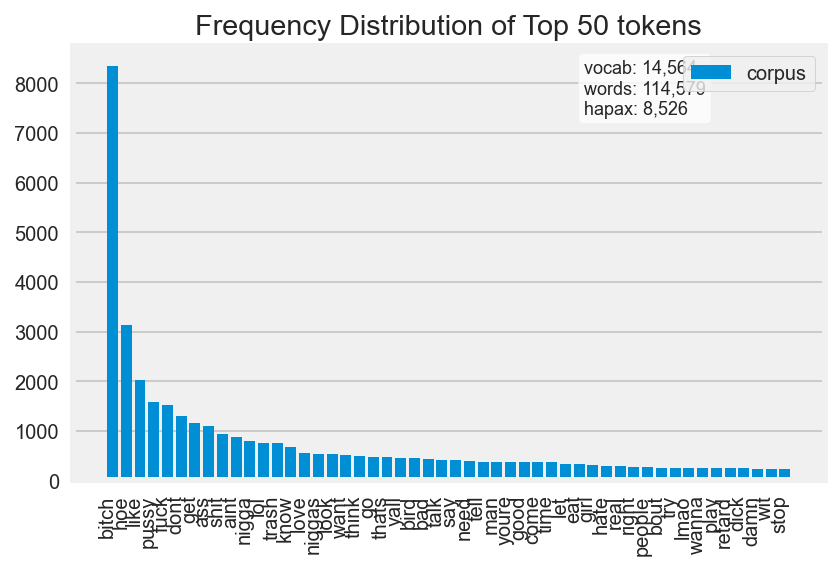

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [120]:
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

FrequencyVisualizer(ax=<AxesSubplot:>,
                    features=['aap', 'absolve', 'abuse', 'accept', 'acceptable',
                              'accord', 'account', 'accuracy', 'act', 'actin',
                              'active', 'activities', 'activity', 'actual',
                              'actually', 'add', 'address', 'admit', 'ads',
                              'advice', 'affection', 'afford', 'aflcio',
                              'africa', 'african', 'age', 'agg', 'ago', 'agree',
                              'ahh', ...],
                    n=None, orient='v')

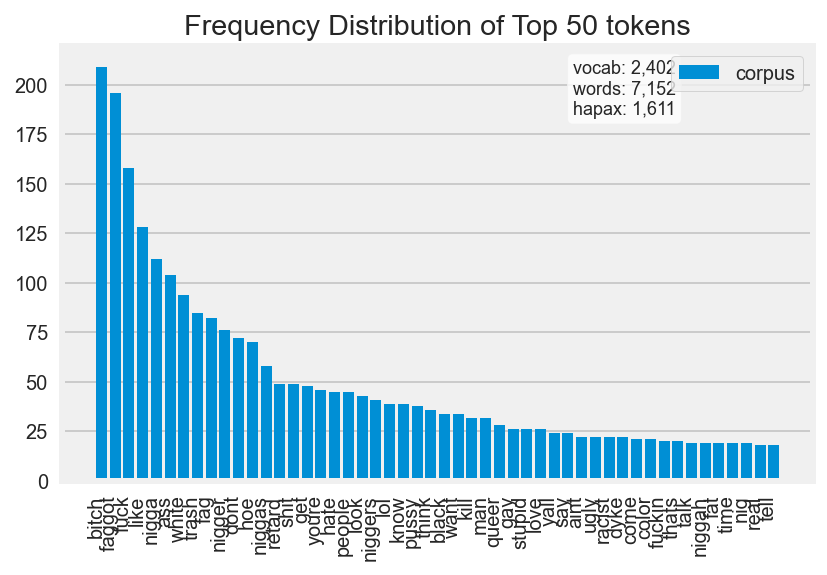

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [121]:
vec = CountVectorizer()
docs = vec.fit_transform(one_tokens)
features = vec.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

## TSNE

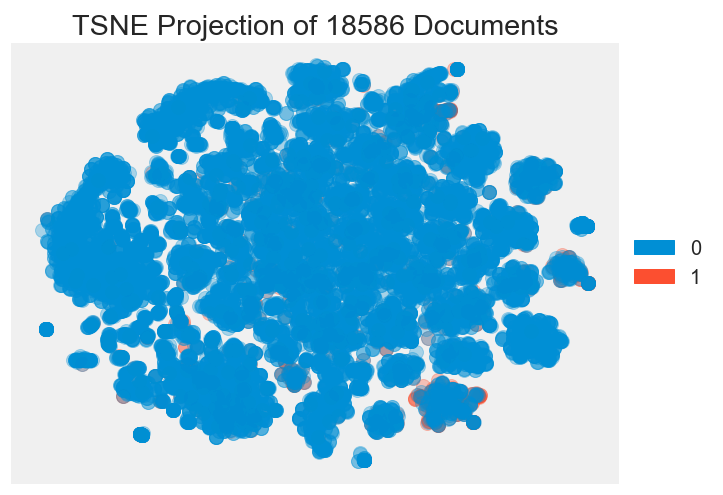

TSNEVisualizer(alpha=0.3,
               ax=<AxesSubplot:title={'center':'TSNE Projection of 18586 Documents'}>,
               decompose=None, decompose_by=None)

In [201]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train.tweet2)
y = train.target

tsne(X, y, alpha=0.3, decompose='svd')

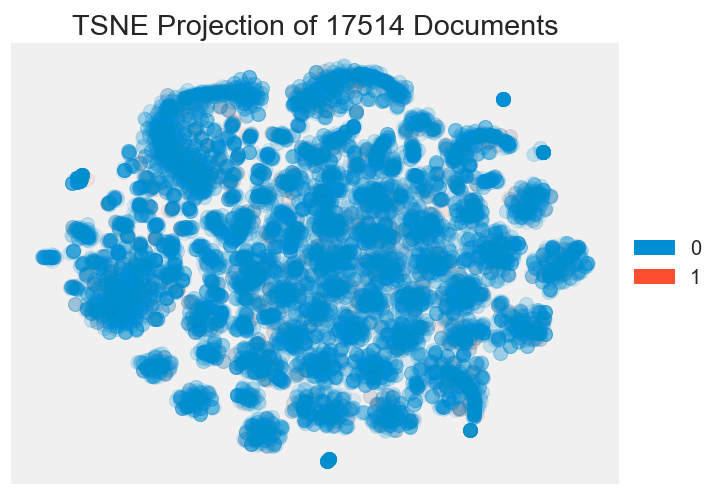

TSNEVisualizer(alpha=0.1,
               ax=<AxesSubplot:title={'center':'TSNE Projection of 17514 Documents'}>,
               decompose=None, decompose_by=None)

In [202]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(zero.tweet2)
y = train.target

tsne(X, y, alpha=0.1, decompose='svd')

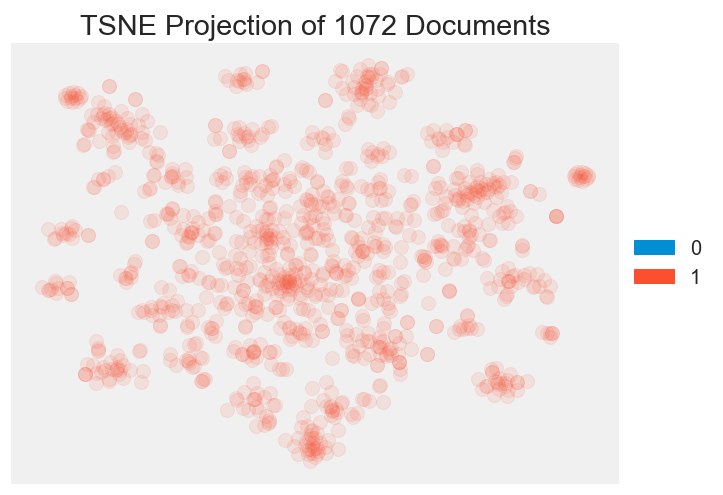

TSNEVisualizer(alpha=0.1,
               ax=<AxesSubplot:title={'center':'TSNE Projection of 1072 Documents'}>,
               decompose=None, decompose_by=None)

In [203]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(one.tweet2)
y = train.target

tsne(X, y, alpha=0.1, decompose='svd')

## Wordcloud

(-0.5, 399.5, 199.5, -0.5)

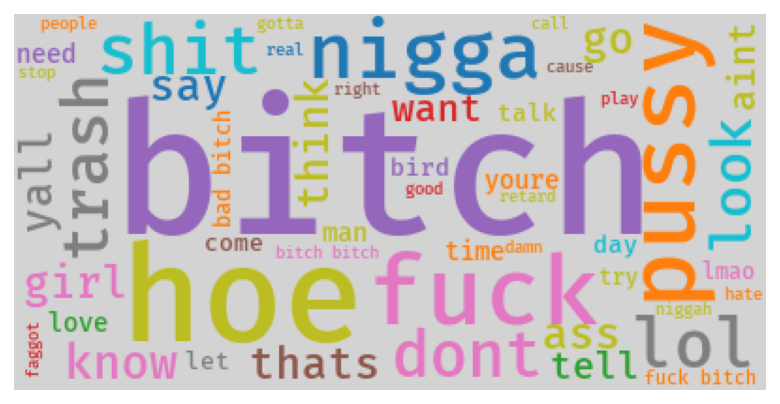

In [136]:
text = ' '.join(zero_tokens)

# Initialize wordcloud object
wc = WordCloud(font_path="/Users/examsherpa/Library/Fonts/FiraMono-Medium.ttf", background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

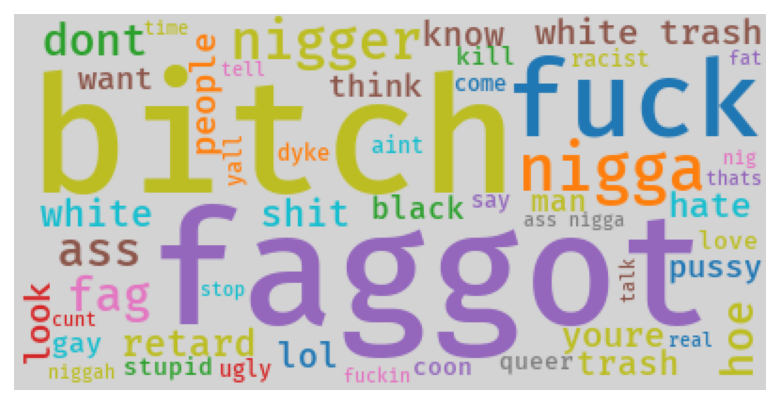

In [137]:
text = ' '.join(one_tokens)

# Initialize wordcloud object
wc = WordCloud(font_path="/Users/examsherpa/Library/Fonts/FiraMono-Medium.ttf", background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

## Bigrams

In [143]:
def combination_of_words(df):
    return TextBlob(" ".join(train.tweet.sum())).ngrams(2)

In [144]:
combination_of_words(train)[:50]

[WordList(['reject', 'constantly']),
 WordList(['constantly', 'house']),
 WordList(['house', 'threaten']),
 WordList(['threaten', 'rape']),
 WordList(['rape', 'mom']),
 WordList(['mom', 'karmas']),
 WordList(['karmas', 'bitch']),
 WordList(['bitch', 'rot']),
 WordList(['rot', 'hell']),
 WordList(['hell', 'faggot']),
 WordList(['faggot', 'convince']),
 WordList(['convince', 'lame']),
 WordList(['lame', 'nigger']),
 WordList(['nigger', 'liver']),
 WordList(['liver', 'believe']),
 WordList(['believe', 'cuz']),
 WordList(['cuz', 'nigger']),
 WordList(['nigger', 'whore']),
 WordList(['whore', 'peace']),
 WordList(['peace', 'fag']),
 WordList(['fag', 'remember']),
 WordList(['remember', 'best']),
 WordList(['best', 'lux']),
 WordList(['lux', 'support']),
 WordList(['support', 'drop']),
 WordList(['drop', 'lustboy']),
 WordList(['lustboy', 'pick']),
 WordList(['pick', 'kakao']),
 WordList(['kakao', 'tsm']),
 WordList(['tsm', 'haha']),
 WordList(['haha', 'ight']),
 WordList(['ight', 'nig']),
 

In [145]:
combination_of_words(val)[:50]

[WordList(['reject', 'constantly']),
 WordList(['constantly', 'house']),
 WordList(['house', 'threaten']),
 WordList(['threaten', 'rape']),
 WordList(['rape', 'mom']),
 WordList(['mom', 'karmas']),
 WordList(['karmas', 'bitch']),
 WordList(['bitch', 'rot']),
 WordList(['rot', 'hell']),
 WordList(['hell', 'faggot']),
 WordList(['faggot', 'convince']),
 WordList(['convince', 'lame']),
 WordList(['lame', 'nigger']),
 WordList(['nigger', 'liver']),
 WordList(['liver', 'believe']),
 WordList(['believe', 'cuz']),
 WordList(['cuz', 'nigger']),
 WordList(['nigger', 'whore']),
 WordList(['whore', 'peace']),
 WordList(['peace', 'fag']),
 WordList(['fag', 'remember']),
 WordList(['remember', 'best']),
 WordList(['best', 'lux']),
 WordList(['lux', 'support']),
 WordList(['support', 'drop']),
 WordList(['drop', 'lustboy']),
 WordList(['lustboy', 'pick']),
 WordList(['pick', 'kakao']),
 WordList(['kakao', 'tsm']),
 WordList(['tsm', 'haha']),
 WordList(['haha', 'ight']),
 WordList(['ight', 'nig']),
 

## Term Frequency

In [146]:
def term_frequency(df):
    tf1 = (df['tweet2'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index())
    tf1.columns = ['words', 'tf']
    tf1 = tf1.sort_values(by='tf', ascending=False).reset_index()
    return tf1

In [147]:
tf1 = term_frequency(train)

AttributeError: 'list' object has no attribute 'split'

In [148]:
tf1.head(10)

NameError: name 'tf1' is not defined

In [129]:
tf2 = term_frequency(val)

In [130]:
tf2.head(10)

index    words       tf
0      0           16436.0
1      3    bitch   2109.0
2     16      the   1850.0
3     12      you   1579.0
4     45      and    951.0
5     27     that    849.0
6     55  bitches    769.0
7     83     like    719.0
8    142     hoes    553.0
9     62     this    549.0

In [165]:
train.head()

tweet  target
0  'reject', 'constantly', 'house', 'threaten', '...       1
1  'convince', 'lame', 'nigger', 'liver', 'believ...       1
2  'peace', 'fag', 'remember', 'best', 'lux', 'su...       1
3            'haha', 'ight', 'nig', 'calm', 'yoself'       1
4  'tits', 'better', 'look', 'face', 'make', 'lik...       1

In [166]:
val.head()

tweet  target
0  'lbum', 'fotos', 'gaywrites', 'make', 'project...       1
1  'yay', 'america', 'israel', 'jew', 'hat', 'mus...       1
2  'miss', 'ofay', 'friends', 'day', 'scar', 'rec...       1
3  'trash', 'darkskin', 'nigga', 'steal', 'damn',...       1
4  'cody', 'call', 'people', 'nigger', 'hes', 'fu...       1

In [167]:
pickle.dump(train, open("../pickle/train.pickle", "wb"))
pickle.dump(val, open("../pickle/val.pickle", "wb"))
pickle.dump(test, open("../pickle/test.pickle", "wb"))

